In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## PHYS 512 - Problem Set 1
Tristan Ménard<br>
260675783
### Problem 1
#### a) 

In [2]:
def fit_truncated_chebyshev(x, y, order, tol=1e-6):
    """
    Returns the best fit chebyshev polynomial to y and truncated to an accuracy of 10^-6 (default tolerance).
    Also returns the number of chebyshev terms needed achieve the desired accuracy.
    x, y : array-like
        x and y values that you want to fit
    order : int
        the order of the chebyshev fit before truncatation
    tol : float
        the desired accuracy of the truncated chebyshev fit
    
    """
    # Rescale the x domain to -1 <= x <= +1. Chebyshev polynomials are well-behaved on this domain.
    xx = np.linspace(-1, 1, len(x))
    
    # Build the Chebyshev polynomial matrix A of the wanted order
    A = np.zeros([len(x), order+1])
    A[:,0] = 1.0
    if order > 0:
        A[:,1] = xx
        for i in range(2, order+1):
            A[:,i] = 2*xx*A[:,i-1] - A[:,i-2]
    
    # Minimize chi-squared
    # Solve np.dot(A.tranpose(), np.dot(Ninv, A))*m = np.dot(A.transpose(), np.dot(A, y)) for m
    # m are the best fit coefficients for the full Chebyshev polynomial
    noise = np.finfo(float).eps # take the noise in each measurement to be the machine precision
    Ninv = np.eye(len(x))/noise**2
    lhs = np.dot(A.transpose(), np.dot(Ninv, A))
    rhs = np.dot(A.transpose(), np.dot(Ninv, y))
    m = np.dot(rhs, np.linalg.inv(lhs))
    
    # Look for coefficients that are larger than the tolerance (=1E-6 by default)
    # nterms is the number of terms to needed to get the accuracy below the tolerance
    nterms = np.sum(np.abs(m) >= tol)
    
    # Truncate the fitted Chebyshev polynomial to nterms
    A_trunc = A[:,:nterms]
    m_trunc = m[:nterms]
    fit_trunc = np.dot(A_trunc, m_trunc)
    
    return fit_trunc, nterms

Number of terms needed: 8
===== Truncated Chebyshev residuals =====
Max Error: 3.1969794078712255e-07
RMS Error: 1.919021819400678e-07
===== Least squares polynomial residuals =====
Max Error: 8.005001195243722e-07
RMS Error: 1.6782509321270313e-07


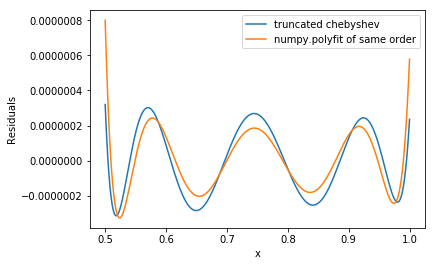

In [3]:
# Want to model log base 2 of x from x = 0.5 to 1
x = np.linspace(0.5,1,2000)
y = np.log2(x)

# Find the best-fit truncated chebyshev to log base 2 of x, and show the error (max vs. rms)
y_fit_trunc, nterms = fit_truncated_chebyshev(x, y, 15)
print('Number of terms needed: '+repr(nterms))
resid_trunc = y_fit_trunc-y
max_err_trunc = np.max(resid_trunc)
rms_err_trunc = np.sqrt(np.mean(resid_trunc**2))
print('===== Truncated Chebyshev residuals =====\nMax Error: '+repr(max_err_trunc)+'\nRMS Error: '+repr(rms_err_trunc))

# Do the same using numpy's least squares polynomial fitting function with the same order as the truncated chebyshev
p = np.polyfit(x, y, nterms-1)
y_fit_poly = np.polyval(p, x)
resid_poly = y_fit_poly-y
max_err_poly = np.max(resid_poly)
rms_err_poly = np.sqrt(np.mean(resid_poly**2))
print('===== Least squares polynomial residuals =====\nMax Error: '+repr(max_err_poly)+'\nRMS Error: '+repr(rms_err_poly))

# Plot the residuals to visualize the comparison in the errors
plt.plot(x, resid_trunc, label='truncated chebyshev')
plt.plot(x, resid_poly, label='numpy.polyfit of same order')
plt.xlabel('x')
plt.ylabel('Residuals')
plt.legend()
plt.show()

So, the truncated Chebyshev fit is much better at the ends of the data, while the regular least squares polynomial fit is better in the central region.

#### b)

Number of terms needed: 55
Max Error: 4.317946151743968e-06


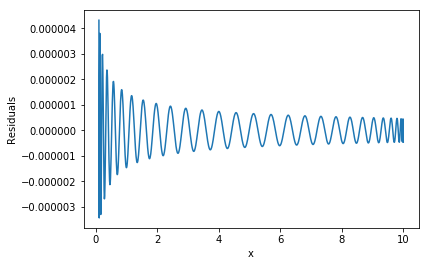

In [4]:
x = np.linspace(0.1,10,1000)
y = np.log2(x)

y_fit_trunc, nterms = fit_truncated_chebyshev(x, y, 100)
print('Number of terms needed: '+repr(nterms))
print('Max Error: '+repr((y_fit_trunc-y).max()))
plt.plot(x, y_fit_trunc-y)
plt.xlabel('x')
plt.ylabel('Residuals')
plt.show()

In [5]:
p = np.polynomial.chebyshev.chebfit(x,y,100)
yy = np.polynomial.chebyshev.chebval(x, p)

C:\Users\Trix\Anaconda3\lib\site-packages\numpy\polynomial\chebyshev.py:1647: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


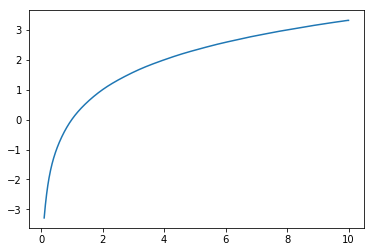

In [6]:
plt.plot(x, yy)
plt.show()

In [7]:
np.frexp(5)

(0.625, 3)

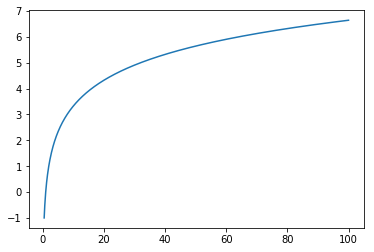

In [8]:
a = np.linspace(0.5,100,1000)
b = np.frexp(a)

plt.plot(a,b[1]+np.log2(b[0]))
plt.show()

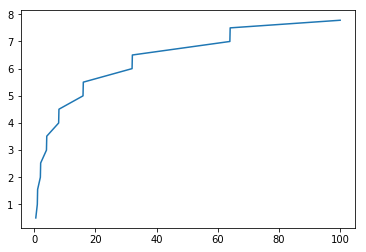

In [9]:
plt.plot(a,b[1]+b[0])
plt.show()

In [10]:
np.logspace(-1,3,9,base=2)

array([0.5       , 0.70710678, 1.        , 1.41421356, 2.        ,
       2.82842712, 4.        , 5.65685425, 8.        ])

In [11]:
np.frexp(5)

(0.625, 3)

In [12]:
np.log2(5)

2.321928094887362

### Problem 2
#### a)

In [13]:
# Import the data
data = np.loadtxt('229614158_PDCSAP_SC6.txt', delimiter=',', skiprows=1)
time = data[:,0]
flux = data[:,1]

Zooming into the region of interest, the flare looks like this.

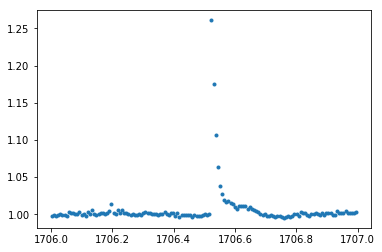

In [14]:
idx = (time>=1706)&(time<=1707)
time_zoomed = time[idx]
flux_zoomed = flux[idx]

plt.plot(time_zoomed, flux_zoomed, '.')
plt.show()

We want to model the flare as a decreasing exponential starting sharply at some critical time $t_C$. The piecewise function that I will take as the model is constant at some flux $D$ for times less than $t_C$. For times greater than $t_C$, the model is a an exponential function of amplitude $A$, that decreases at some rate $B$ back to a flux of $D$. This is a non-linear model.

$$
f(t) = \begin{cases} 
        D & t < t_C \\ 
        Ae^{-B(t-t_C)}+D & t \geq t_C 
        \end{cases}
$$

For my initial guess of the parameters, I will use:

$
\begin{align}
A &= 0.3 \\
B &= 30 \\
D &= 1 \\
t_C &= 1706.52
\end{align}
$

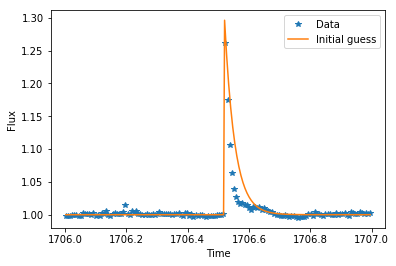

In [15]:
# Plot the model over the region of interest using my initial guesses for the parameters.
A = 0.3
B = 30
D = 1
tC = 1706.52

x = np.linspace(time_zoomed[0], time_zoomed[-1], 300)
f = [D if t < tC else A*np.exp(-B*(t-tC))+D for t in x]

plt.plot(time_zoomed, flux_zoomed, '*', label='Data')
plt.plot(x, f, label='Initial guess')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

#### b)

I want to minimize the $\chi^2$ while keeping the flare starting time fixed at my initial guess of $t_C=1706.52$.

Using Newton's Method, I can get the non-linear fit to the data with the derivatives of the model $f(t)$ with respect to each variable parameter ($A$, $B$, and $D$). 

In [16]:
def model_derivs(pars, x, tC):
    """
    Returns the model evaluated for the input parameters (pars and tC).
    Also returns the analytic derivatives of the model function taken with respect to each variable parameter of the model.
    pars : list or array-like
        The parameters of the model in the following order [A, B, D]
    x : array-like
        The x values
    tC : float
        The fixed flare starting time
    
    """
    A = pars[0]
    B = pars[1]
    D = pars[2]
    expvec = np.asarray([0 if t < tC else np.exp(-B*(t-tC)) for t in x])
    fun = A*expvec+D
    dA = expvec
    dB = (tC-x)*A*expvec
    dD = 1.0
    derivs = np.zeros([len(x), len(pars)])
    derivs[:,0] = dA
    derivs[:,1] = dB
    derivs[:,2] = dD
    return fun, derivs

In [17]:
n = 6 # Want to iterate through the fitting procedure several times to find an adequate minimum of chi-squared
pars = [A, B, D]
# all_fun will hold all the fitted-flux values for every iteration of the non-linear fitting procedure
all_fun = np.zeros([len(x), n+1])

fun, derivs = model_derivs(pars, time_zoomed, tC) # the initial guess model
resid = flux_zoomed - fun
# chi_old = np.sum(resid**2)
fun1, _ = model_derivs(pars, x, tC) # a higher resolution version of the current iteration of the model
all_fun[:,0] = fun1 # keep the higher resolution version for plotting later

for i in range(1,n+1):    
    grad = 2*np.dot(derivs.transpose(), resid)
    curve = 2*np.dot(derivs.transpose(), derivs)
    covariance = np.linalg.inv(curve)
    pars = pars + np.dot(covariance, grad)
    
    fun, derivs = model_derivs(pars, time_zoomed, tC)
    resid = flux_zoomed - fun
#     chi_new = np.sum(resid**2)
    fun1, _ = model_derivs(pars, x, tC)
    all_fun[:,i] = fun1
    
#     print('Change in chi-squared is '+repr(chi_new-chi_old))
    
#     chi_old = chi_new
    
print('Best-fit parameters are:\nA = '+repr(pars[0])+'\nB = '+repr(pars[1])+'\nD = '+repr(pars[2]))

Best-fit parameters are:
A = 0.31959378641553476
B = 64.16548944349027
D = 1.001130038184151


The best-fit parameters are given above.

Below, I show an animation of the model as it minimizes $\chi^2$ and approaches the best-fit parameters.

<IPython.core.display.Javascript object>


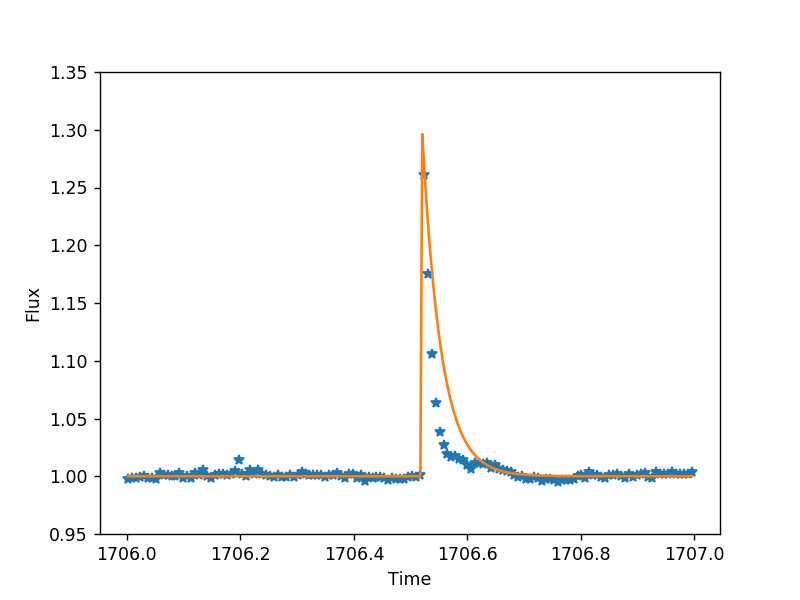

In [19]:
%matplotlib notebook
fig, ax = plt.subplots()

ax.plot(time_zoomed, flux_zoomed, '*')
newline, = ax.plot([], [])
ax.set_ylim([0.95, 1.35])
ax.set_xlabel('Time')
ax.set_ylabel('Flux')

def update(i):
    newline.set_data(x, all_fun[:,i])
    return newline,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, update, frames=10, interval=1000, blit=True, repeat=True)

fig.show()

Finally, here is the direct comparison between the initial guess and the best fit.

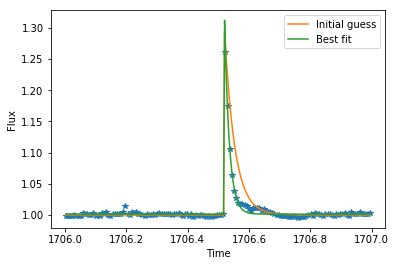

In [21]:
%matplotlib inline
plt.plot(time_zoomed, flux_zoomed, '*')
plt.plot(x, f, label='Initial guess')
plt.plot(x, fun1, label='Best fit')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

#### c)

The error on the fit parameters is given by the diagonal elements of the covariance matrix (the covariance matrix is the inverse of the curvature matrix).

In [22]:
print('Best-fit parameters are:')
print('A = '+repr(pars[0])+' +/- '+repr(np.diag(covariance)[0]))
print('B = '+repr(pars[1])+' +/- '+repr(np.diag(covariance)[1]))
print('D = '+repr(pars[2])+' +/- '+repr(np.diag(covariance)[2]))

Best-fit parameters are:
A = 0.31959378641553476 +/- 0.9344227974460411
B = 64.16548944349027 +/- 78552.53853554961
D = 1.001130038184151 +/- 0.0037071539043971096


The errors for $A$ and $B$ are clearly unreasonable. For example, if $A\approx0.32-0.93=-0.61$, then the model would extend downwards from $D$ before returning exponentially to $D$, and the model would completely fail to describe the data. Also, if $B$ is allowed to be negative, then the model would describe another completely different scenario in which the flux increases exponentially with time after the flare starting time.

At least on the local scale the error for $D$ appear to be reasonable, as the fit between the data and the model is quite tight in this region.

#### d)

Looking at the full dataset, it appears that the error on $D$ is unreasonably small. There seems to be some periodic effect in the flux baseline that the model does not account for. So, I would not consider the errors on the non-linear fit to be trustworthy in any capacity.

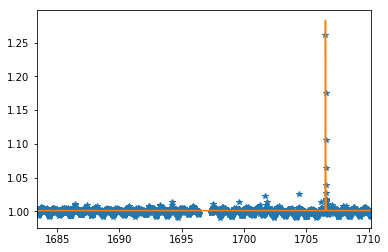

In [23]:
xx = np.linspace(time[0], time[-1], 1000)
funxx, _ = model_derivs(pars, xx, tC)
plt.plot(time, flux, '*')
plt.plot(xx, funxx)
plt.xlim(time[0],time[-1])
plt.show()